#follow this to install prismnet
https://github.com/kuixu/PrismNet

In [1]:
import argparse, os, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn import metrics
import numpy as np
from prismnet.model.utils import GradualWarmupScheduler
from prismnet.utils import datautils

# modified code
from model import PrismNet_Multitask
from dataloader_unmask import SeqicSHAPE_Multitask

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def train(model, device, train_loader, criterion, optimizer):
    ''' train for one epoch'''
    model.train()
    epoch_loss = 0
    for batch_idx, (x0, y0) in enumerate(train_loader):
        x, y = x0.float().to(device), y0.to(device).float()
        
        optimizer.zero_grad()
        output = model(x)
        
        loss = criterion(output, y)
        epoch_loss+=loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

    return epoch_loss
def validate(model, device, test_loader, criterion):
    model.eval()
    y_all = []
    p_all = []
    l_all = []
    epoch_loss = 0
    with torch.no_grad():
        for batch_idx, (x0, y0) in enumerate(test_loader):
            x, y = x0.float().to(device), y0.to(device).float()
            
            
            output  = model(x)
            loss = criterion(output, y)
            
            epoch_loss += loss.item()
            y_np = output.to(device='cpu', dtype=torch.float32).numpy()
            y_all.append(y_np)
            
    y_pred=np.concatenate(y_all)
    return epoch_loss, y_pred

In [3]:
outstem = 'K562_rep6'
rbp = 'PUM2'
megaoutput = pd.read_csv(f'../data/ABC_data/{outstem}.megaoutputs_masked.tsv', sep = '\t')
seq = pd.read_csv(f'../data/ABC_data/tsv/{outstem}.DDX3.tsv', sep = '\t', names = ['chrom', 'name', 
                                                                                 'seq', 'struct', 'label', 'start'])
# read variants
variants = pd.read_csv(f'../data/variant_clinvar/{outstem}.{rbp}.csv')
max_length=seq['seq'].str.len().max()
variants = variants.loc[variants['variant_seq'].str.len()<=max_length]

# also score normal things
seq = seq.loc[seq['name'].isin(variants['name'])]

# convert to neural network input formats
one_hot_wt = datautils.convert_one_hot(seq['seq'], max_length)
one_hot_var = datautils.convert_one_hot(variants['variant_seq'], max_length)

# targets: predict binary
target_col = megaoutput.columns[(megaoutput.columns.str.startswith('logLR'))&(megaoutput.columns.str.contains(outstem))]
target_df = megaoutput.set_index('name').loc[seq['name'],target_col]
targets_wt = target_df.values
targets_var = variants.merge(target_df, left_on = 'name', right_index = True)[target_df.columns].values

# load model
model = PrismNet_Multitask(mode = 'seq', output_dim = targets_wt.shape[1])
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(device)
model.load_state_dict(torch.load(f'../data/ABC_data/{outstem}.maskw.model.pt'))

# load into dataloader
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
test_loader  = torch.utils.data.DataLoader(
    SeqicSHAPE_Multitask(one_hot_wt, targets_wt, is_infer=False, use_structure=False),
batch_size=64*8, shuffle=False, **kwargs)

test_loader_var  = torch.utils.data.DataLoader(
    SeqicSHAPE_Multitask(one_hot_var, targets_var, is_infer=False, use_structure=False),
batch_size=64*8, shuffle=False, **kwargs)


print("Test  set:", len(test_loader.dataset))
print("Test  set:", len(test_loader_var.dataset))


criterion = torch.nn.MSELoss()

# inference
loss_test, y_pred = validate(model, device, test_loader, criterion)
loss_test_var, y_pred_var = validate(model, device, test_loader_var, criterion)

# join variant scores
y_pred_var_df = pd.DataFrame(y_pred_var, index = variants.index, columns = target_df.columns)
y_pred_wt_df = pd.DataFrame(y_pred, index = seq['name'], columns = target_df.columns)
variants[f'variant_score_{rbp}'] = y_pred_var_df[f'logLR:{outstem}.{rbp}']
variants[f'wt_score_{rbp}'] = variants['name'].map(y_pred_wt_df[f'logLR:{outstem}.{rbp}'])
variants['delta_score'] = (variants[f'variant_score_{rbp}']-variants[f'wt_score_{rbp}'])

Test  set: 88
Test  set: 403


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [4]:
from saliency import get_saliency

# making saliency is slow, make smaller subset
neg_selected_var = variants.loc[(variants['delta_score']<-0.5)]
gof_var = variants.loc[(variants['delta_score']>1)]

# calculate index in tensor
neg_selected_var['rbp_idx'] = np.arange(neg_selected_var.shape[0])
seq['rbp_idx'] = np.arange(seq.shape[0])
gof_var['rbp_idx'] = np.arange(gof_var.shape[0])



/tmp/ipykernel_4112/1490969642.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_selected_var['rbp_idx'] = np.arange(neg_selected_var.shape[0])


True

In [9]:
# get into dataloader
one_hot_negvar = datautils.convert_one_hot(neg_selected_var['variant_seq'], max_length)
targets_var = neg_selected_var.merge(target_df, left_on = 'name', right_index = True)[target_df.columns].values


test_loader_negvar  = torch.utils.data.DataLoader(
    SeqicSHAPE_Multitask(one_hot_negvar, targets_var, is_infer=False, use_structure=False),
batch_size=64*8, shuffle=False, **kwargs)

# get into dataloader
if not gof_var.empty:
    one_hot_gofvar = datautils.convert_one_hot(gof_var['variant_seq'], max_length)
    targets_gofvar = gof_var.merge(target_df, left_on = 'name', right_index = True)[target_df.columns].values

    test_loader_gofvar  = torch.utils.data.DataLoader(
        SeqicSHAPE_Multitask(one_hot_gofvar, targets_gofvar, is_infer=False, use_structure=False),
    batch_size=64*8, shuffle=False, **kwargs)


In [10]:
saliency_wt = get_saliency(model, test_loader, rbp, target_col)
saliency_var = get_saliency(model, test_loader_negvar, rbp, target_col)
if not gof_var.empty:
    saliency_gofvar = get_saliency(model, test_loader_gofvar, rbp, target_col)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [11]:
# visualization
!pip install pybigwig
!pip install logomaker

You should consider upgrading via the '/opt/conda/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.9 -m pip install --upgrade pip' command.


In [12]:

import pyBigWig
import numpy as np

class strand_specific_wig:
    def __init__(self, plus, minus):
        self.plus = pyBigWig.open(plus)
        self.minus = pyBigWig.open(minus)
        
    def fetch(self, chrom = None, start= None, end=None, strand= None, interval = None):
        ''' return icSHAPE reacitivity for a bedtool interval or chrom, start, end, strand'''
        if interval:
            start = interval.start
            end = interval.end
            strand = interval.strand
            chrom = interval.chrom
        if strand == '-':
            icshape_data = self.minus
        else:
            icshape_data = self.plus
        values = icshape_data.values(chrom, start, end)
        if strand == '-':
            values = values[::-1]
        return np.nan_to_num(np.array(values), 0)

In [13]:
rbp_wig_cits = strand_specific_wig(f'../data/CITS/{rbp}.pos.bw',
                                 f'../data/CITS/{rbp}.neg.bw'
                                 )
rbp_wig_cov = strand_specific_wig(f'../data/COV/{rbp}.pos.bw',
                             f'../data/COV/{rbp}.neg.bw'
                             )

In [14]:
import seaborn as sns
import logomaker
import matplotlib.pyplot as plt

def plot_saliency(gs, index, subset_seq_df, one_hot):
    index2seq = 'ACGU'
    

    # find coverage
    window_name = subset_seq_df.iloc[index]['name']
    print(window_name)
    row = megaoutput.loc[megaoutput['name']==window_name].iloc[0]
    wig_values = rbp_wig_cov.fetch(row['chrom'], row['start'], row['end'], row['strand'])
    wig_values_cits = rbp_wig_cits.fetch(row['chrom'], row['start'], row['end'], row['strand'])

    seq_values = one_hot[index,:,:] # [1,4,100]
    gradient_values = gs[index,0,:,:].cpu().numpy() # [1,1,100,4]
    saliency_values = gradient_values * seq_values.T # 4*100
    saliency_df = pd.DataFrame(saliency_values.T)
    saliency_df.index = list(index2seq)

    saliency_df = saliency_df.loc[:, seq_values.sum(axis = 0)!=0].T
    saliency_df.index = np.arange(saliency_df.shape[0])

    f, ax = plt.subplots(2,1, sharex = True, figsize = (12,4))
    logomaker.Logo(saliency_df, # only plot places with sequence
                              shade_below=.5,
                              fade_below=.5,
                              font_name='Arial Rounded MT Bold', 
                  ax = ax[0])


    ax[0].set_ylabel('saliency')
    ax[1].bar(np.arange(len(wig_values)), wig_values, color = 'lightgrey')
    ax[1].set_ylabel('coverage')
    ax[0].set_title(row['chrom'] + ':'+str(row['start'])+'-'+str(row['end'])+':'+row['strand'])
    sns.despine()
    
    if 'POS' in subset_seq_df.iloc[index]:
        print(subset_seq_df.iloc[index]['POS']-row['start'])
        if row['strand']=='+':
            index = subset_seq_df.iloc[index]['POS']-row['start']
            
        else:
            index = row['end']-subset_seq_df.iloc[index]['POS']
        ax[0].text(index-0.5, max(saliency_values[index,:]), '*')

# Visualize saliency

In [15]:
#neg_selected_var.loc[neg_selected_var['gene_name']=='POLD1'] # RBFOX2
neg_selected_var.loc[neg_selected_var['gene_name']=='CDKN1B'] # RBFOX2

,Unnamed: 0,CHROM,POS,ID,REF,ALT,name,variant_seq,feature_type_top,feature_types,gene_name,transcript_types,transcript_type_top,INFO/CLNDN,INFO/CLNVC,INFO/CLNSIG,variant_score_PUM2,wt_score_PUM2,delta_score,rbp_idx
31,61,chr12,12722100,307690,C,T,3778767,AACCATTTGAAGTGTACCTGTGTATATAACTCTGTAAAAACACTGA...,UTR3,UTR3:EXON_MRNA,CDKN1B,protein_coding,protein_coding,Multiple_endocrine_neoplasia_type_4,single_nucleotide_variant,Uncertain_significance,0.937332,2.057527,-1.120195,1


In [24]:
neg_selected_var

,Unnamed: 0,CHROM,POS,ID,REF,ALT,name,variant_seq,feature_type_top,feature_types,gene_name,transcript_types,transcript_type_top,INFO/CLNDN,INFO/CLNVC,INFO/CLNSIG,variant_score_PUM2,wt_score_PUM2,delta_score,rbp_idx
13,31,chr10,110604338,879046,A,G,3345901,TTGGAAAATACTACCTACTGGTTTGGGAGATGTATGTAGTAATATG...,UTR3,UTR3:EXON_MRNA,SMC3,protein_coding,protein_coding,Cornelia_de_Lange_syndrome_3,single_nucleotide_variant,Uncertain_significance,-0.188689,1.541439,-1.730128,0
31,61,chr12,12722100,307690,C,T,3778767,AACCATTTGAAGTGTACCTGTGTATATAACTCTGTAAAAACACTGA...,UTR3,UTR3:EXON_MRNA,CDKN1B,protein_coding,protein_coding,Multiple_endocrine_neoplasia_type_4,single_nucleotide_variant,Uncertain_significance,0.937332,2.057527,-1.120195,1
91,214,chr3,38484965,902008,C,G,1077073,AAAGTTTGCATCTTCTAGGGAGTGCTACCATTTTTGTTTGATAACG...,UTR3,UTR3:EXON_MRNA,ACVR2B,protein_coding,protein_coding,"Heterotaxy,_visceral,_4,_autosomal",single_nucleotide_variant,Uncertain_significance,0.289342,0.974820,-0.685477,2
121,248,chr3,197951294,2070883,T,C,1221347,GCACACAGCTCTTCTTAAAATTGAAGGTGTTTACGCCCGAGATGAA...,CDS_STOP,CDS_STOP:CDS:EXON_MRNA:EXON_LNCRNA:SS5_ADJ:SS5...,RPL35A,protein_coding:retained_intron:nonsense_mediat...,protein_coding,Diamond-Blackfan_anemia_5,single_nucleotide_variant,Likely_benign,-0.018414,0.986099,-1.004513,3
312,177,chr2,96274951,337522,A,G,917623,GTCCTGAGGCATTTACTTTTGGGTAAAGGAGAGTTGAGCCTGAATT...,UTR3,UTR3:EXON_MRNA,SNRNP200,protein_coding:retained_intron,protein_coding,Retinitis_pigmentosa,single_nucleotide_variant,Uncertain_significance,-0.294685,0.239152,-0.533837,4


3778767
25
3778767


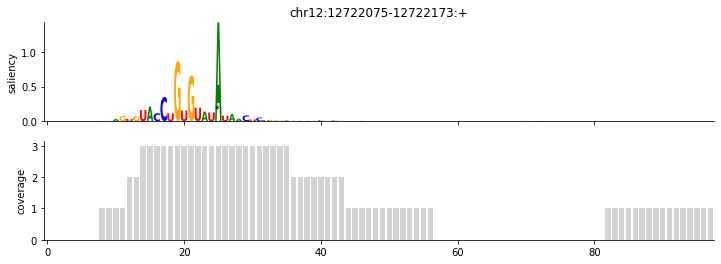

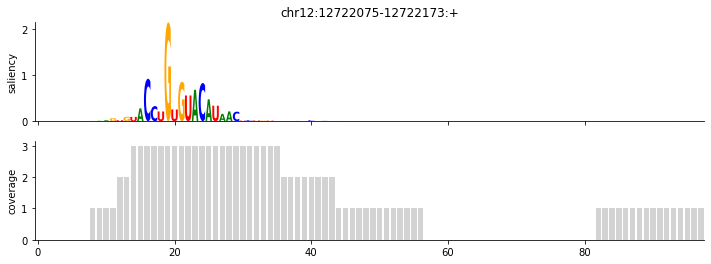

In [36]:
var_idx = 1

# ALT
plot_saliency(saliency_var, var_idx, neg_selected_var, one_hot_negvar)

# REF
plot_saliency(saliency_wt, seq.loc[seq['name']==neg_selected_var.iloc[var_idx]['name'], 'rbp_idx'].values[0],
              seq, one_hot_wt)

In [29]:
def plot_saliency_wt_vs_var(gs, index, subset_seq_df, one_hot, # REF
                           gs_var, index_var, subset_seq_df_var, one_hot_var, # ALT
                            figsize = (10,4)
                           ):
    # metadata
    index2seq = 'ACGU'
    window_name = subset_seq_df.iloc[index]['name']
    print(window_name)
    row = megaoutput.loc[megaoutput['name']==window_name].iloc[0]
    print(row['gene_name'])
    

    # find coverage
#     
#     wig_values = rbp_wig_cov.fetch(row['chrom'], row['start'], row['end'], row['strand'])
#     wig_values_cits = rbp_wig_cits.fetch(row['chrom'], row['start'], row['end'], row['strand'])
    
    f, ax = plt.subplots(2,1, sharex = True, figsize = figsize)
    # REF
    seq_values = one_hot[index,:,:] # [1,4,100]
    gradient_values = gs[index,0,:,:].cpu().numpy() # [1,1,100,4]
    saliency_values = gradient_values * seq_values.T # 4*100
    saliency_df = pd.DataFrame(saliency_values.T)
    saliency_df.index = list(index2seq)
    saliency_df = saliency_df.loc[:, seq_values.sum(axis = 0)!=0].T
    saliency_df.index = np.arange(saliency_df.shape[0])
    
    # ALT
    seq_values_var = one_hot_var[index_var,:,:] # [1,4,100]
    gradient_values_var = gs_var[index_var,0,:,:].cpu().numpy() # [1,1,100,4]
    saliency_values_var = gradient_values_var * seq_values_var.T # 4*100
    saliency_df_var = pd.DataFrame(saliency_values_var.T)
    saliency_df_var.index = list(index2seq)
    saliency_df_var = saliency_df_var.loc[:, seq_values_var.sum(axis = 0)!=0].T
    saliency_df_var.index = np.arange(saliency_df_var.shape[0])
    
    

    
    
    
    logomaker.Logo(saliency_df_var, # only plot places with sequence
                              shade_below=.5,
                              fade_below=.5,
                              font_name='Arial Rounded MT Bold', 
                  ax = ax[1])
    
    logomaker.Logo(saliency_df, # only plot places with sequence
                              shade_below=.5,
                              fade_below=.5,
                              font_name='Arial Rounded MT Bold', 
                  ax = ax[0])


    ax[0].set_ylabel('REF saliency')
    ax[1].set_ylabel('ALT saliency')
    
    
    ax[0].set_title(row['chrom'] + ':'+str(row['start'])+'-'+str(row['end'])+':'+row['strand'])
    sns.despine()
    
    if 'POS' in subset_seq_df_var.iloc[index_var]:
        
        print(subset_seq_df_var.iloc[index_var]['POS']-row['start'])
        if row['strand']=='+':
            nu_index = subset_seq_df_var.iloc[index_var]['POS']-row['start']-1
            
        else:
            nu_index = row['end']-subset_seq_df_var.iloc[index_var]['POS']
        ax[1].text(nu_index-0.5, max(saliency_values_var[nu_index,:]), '*')

3345901
SMC3
36


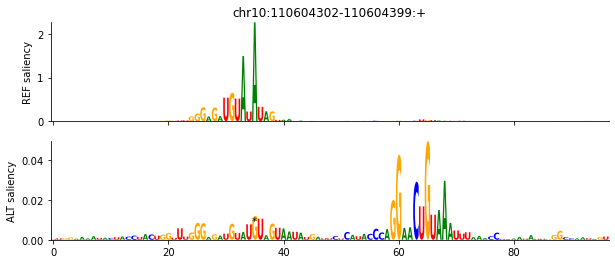

In [39]:
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42

var_idx = 0

# ALT
plot_saliency_wt_vs_var(
    saliency_wt, seq.loc[seq['name']==neg_selected_var.iloc[var_idx]['name'], 'rbp_idx'].values[0],
              seq, one_hot_wt,
    saliency_var, var_idx, neg_selected_var, one_hot_negvar)

plt.savefig('PUM2_SMC3_variants.pdf')

3778767
CDKN1B
25


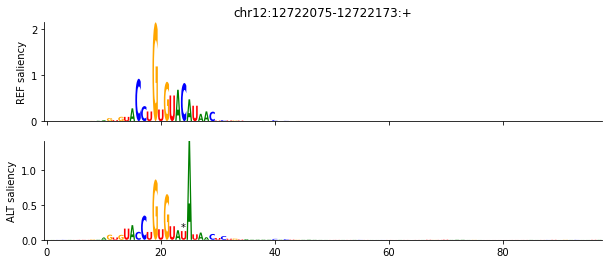

In [40]:

var_idx = 1

# ALT
plot_saliency_wt_vs_var(
    saliency_wt, seq.loc[seq['name']==neg_selected_var.iloc[var_idx]['name'], 'rbp_idx'].values[0],
              seq, one_hot_wt,
    saliency_var, var_idx, neg_selected_var, one_hot_negvar)

plt.savefig('PUM2_CDKN1B_variants.pdf')

917623
SNRNP200
37


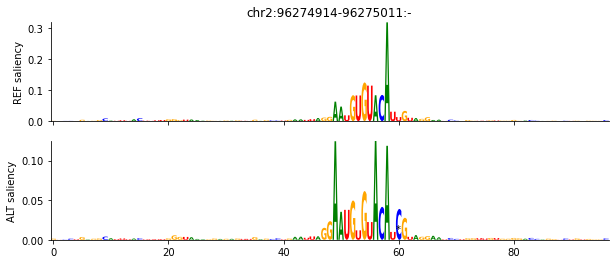

In [41]:

var_idx = 4

# ALT
plot_saliency_wt_vs_var(
    saliency_wt, seq.loc[seq['name']==neg_selected_var.iloc[var_idx]['name'], 'rbp_idx'].values[0],
              seq, one_hot_wt,
    saliency_var, var_idx, neg_selected_var, one_hot_negvar)

plt.savefig('PUM2_SNRNP200_variants.pdf')